### Import

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import seaborn as sns

from datetime import datetime

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, precision_score, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import f_classif, mutual_info_classif

from imblearn.under_sampling import RandomUnderSampler

# from xgboost import XGBRegressor, XGBClassifier
# from lightgbm import LGBMRegressor, LGBMClassifier

RANDOM_SEED = 42

!pip freeze > requirements.txt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Вспомогательные функции

In [3]:
def get_value_balance(df, column):
    count = pd.DataFrame(df[column].value_counts())
    total = len(df[column])
    null_count = len(df[df[column].isna() == True])
    null_percent = round((null_count/total)*100, 2)
    print(df[column].describe(), '\n', '\n',
          'Кол-во пустых значений: {n} ({np}%)'.format(n=null_count, np=null_percent))

    fig, ax = plt.subplots()
    data = ax.barh(y=count.index,
                   width=count.iloc[:, 0],
                   color=['tab:blue', 'tab:orange'])

    for i in data:
        width = i.get_width()
        height = i.get_height()
        ax.annotate('{w} ({p}%)'.format(w=width, p=round((width/total)*100, 2)),
                    xy=(3, i.get_y() + height / 2),
                    ha='left',
                    va='center')

    ax.set_xlabel('Count')
    ax.set_ylabel(count.columns[0])


def get_outlier_iqr(df, column):
    perc75 = df[column].quantile(q=0.75, interpolation='midpoint')
    perc25 = df[column].quantile(q=0.25, interpolation='midpoint')
    iqr = perc75-perc25

    cols = df[column].value_counts().index

    # границы выбросов
    upper_bound = perc75+1.5*iqr
    lower_bound = perc25-1.5*iqr

    print('\n 25-й перцентиль: {}, \n'.format(round(perc25, 3)),
          '75-й перцентиль: {}, \n'.format(round(perc75, 3)),
          'IQR: {}, \n'.format(round(iqr, 3)),
          'Границы выбросов: [{f}<->{l}]\n'.format(f=round(lower_bound, 3), l=round(upper_bound, 3)))


def get_metrics(Y_test, Y_pred):
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f_score = f1_score(Y_test, Y_pred)
    
    print('\n Accuracy: {} \n'.format(round(accuracy, 3)),
          'Precision: {} \n'.format(round(precision, 3)),
          'Recall: {} \n'.format(round(recall, 3)),
          'F1_score: {}'.format(round(f_score, 3)))


def plot_roc_auc(Y_test, Y_prob):
    roc_auc = roc_auc_score(Y_test, Y_prob)
    fpr, tpr, threshold = roc_curve(Y_test, Y_prob)

    plt.figure(figsize=(10, 7))
    plt.plot([0, 1], "b", label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, "r-", label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()


def plot_pr_curve(Y_test, Y_prob):
    precision, recall, threshold = precision_recall_curve(Y_test, Y_prob)
    
    plt.figure(figsize=(10, 7))
    plt.plot(threshold, precision[:-1], "r-", label="Precision")
    plt.plot(threshold, recall[:-1], "b", label="Recall")
    plt.xlabel("threshold")
    plt.legend(loc='upper right')
    plt.show()


def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Data

In [4]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

#### Описания полей

- `client_id` - идентификатор клиента
- `education` - уровень образования
- `sex` - пол заемщика
- `age` - возраст заемщика
- `car` - флаг наличия автомобиля
- `car_type` - флаг автомобиля иномарки
- `decline_app_cnt` - количество отказанных прошлых заявок
- `good_work` - флаг наличия “хорошей” работы
- `bki_request_cnt` - количество запросов в БКИ
- `home_address` - категоризатор домашнего адреса
- `work_address` - категоризатор рабочего адреса
- `income` - доход заемщика
- `foreign_passport` - наличие загранпаспорта
- `sna` - связь заемщика с клиентами банка
- `first_time` - давность наличия информации о заемщике
- `score_bki` - скоринговый балл по данным из БКИ
- `region_rating` - рейтинг региона
- `app_date` - дата подачи заявки
- `default` - флаг дефолта по кредиту

#### Объединение для предобработки

In [5]:
df_train['train'] = 1

df_test['train'] = 0
df_test['default'] = 0

df = df_train.append(df_test, sort=False).reset_index(drop=True)

In [6]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


### Обзор данных

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [8]:
for i in list(df.columns):
    print('Column "{}": {}'.format(i, df[i].nunique()))

Column "client_id": 110148
Column "app_date": 120
Column "education": 5
Column "sex": 2
Column "age": 52
Column "car": 2
Column "car_type": 2
Column "decline_app_cnt": 24
Column "good_work": 2
Column "score_bki": 102618
Column "bki_request_cnt": 40
Column "region_rating": 7
Column "home_address": 3
Column "work_address": 3
Column "income": 1207
Column "sna": 4
Column "first_time": 4
Column "foreign_passport": 2
Column "default": 2
Column "train": 2


##### Выводы:
- Пропуски есть только в `education`

#### Сортировка параметров

In [9]:
# Подготовим списки
categorical = [] # categorical variables
numerical = []   # numerical variables
binary = []      # binary variables

### Целевой параметр

count    73799.000000
mean         0.126994
std          0.332968
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64 
 
 Кол-во пустых значений: 0 (0.0%)


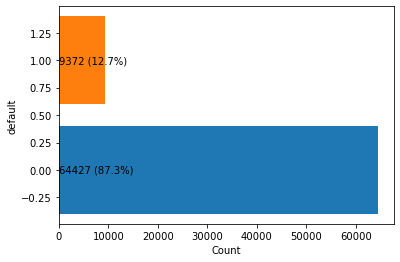

In [10]:
get_value_balance(df_train, 'default')

##### Выводы:
- Имеем сильный дисбаланс классов (_см. Подготовка данных к машинному обучению_)

### EDA

### client_id - идентификатор клиента

Повторяющихся идентификатор нет $\to$ удалим

In [11]:
df=df.drop('client_id', axis=1)

### app_date - дата подачи заявки

Преобразуем object $\to$ date

In [12]:
df['app_date'] = pd.to_datetime(df['app_date'])

In [13]:
df['app_date'].head(1)

0   2014-02-01
Name: app_date, dtype: datetime64[ns]

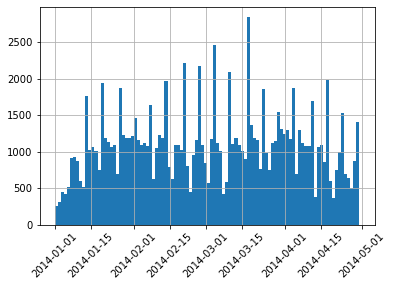

In [14]:
df['app_date'].hist(bins=100, xrot=45);

##### Выводы:
- Представлены данные за 5 месяцев 2014 года $\to$ до [Валютный кризис в России (2014—2015)](https://ru.wikipedia.org/wiki/%D0%92%D0%B0%D0%BB%D1%8E%D1%82%D0%BD%D1%8B%D0%B9_%D0%BA%D1%80%D0%B8%D0%B7%D0%B8%D1%81_%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8_(2014%E2%80%942015)) период
- Распределение достаточно равномерное
- Извлечем month, day

In [15]:
df['app_date_month'] = df['app_date'].apply(lambda x: x.month)
df['app_date_day'] = df['app_date'].apply(lambda x: x.day)

### education - уровень образования

count     109670
unique         5
top          SCH
freq       57998
Name: education, dtype: object 
 
 Кол-во пустых значений: 478 (0.43%)


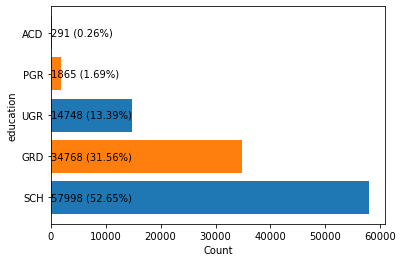

In [16]:
get_value_balance(df, 'education')

- `SCH` - School
- `GRD` - Graduate/Master Level
- `UGR` - [Undergraduate research](https://en.wikipedia.org/wiki/Undergraduate_research)
- `PGR` - [Postgraduate research](https://en.wikipedia.org/wiki/Postgraduate_research)
- `ACD` - Academic(?)

In [17]:
# Заполним пропуски наиболее частым значением
df['education'].fillna(df['education'].value_counts().idxmax(), inplace=True)

In [18]:
# Encode a categorical variable
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])
# Раскидаваем по столбцам
df_education = pd.get_dummies(df['education'])
df_education.columns = le.classes_
# Добавляем в df
df = df.merge(df_education, left_index=True, right_index=True)

In [19]:
# Стандартизируем значения
scaler = StandardScaler()
# scaler = MinMaxScaler()
df['education_norm'] = scaler.fit_transform(df[['education']])

In [20]:
## Сортируем
categorical += ['education', 'education_norm']
# binary += list(le.classes_)

### sex - пол заемщика

count     110148
unique         2
top            F
freq       61836
Name: sex, dtype: object 
 
 Кол-во пустых значений: 0 (0.0%)


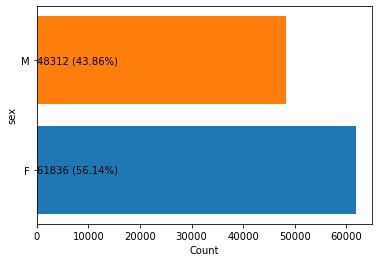

In [21]:
get_value_balance(df, 'sex')

In [22]:
# Encode a categorical variable
df['sex'] = le.fit_transform(df['sex'])

In [23]:
## Сортируем
binary.append('sex')

### age - возраст заемщика

In [24]:
df['age'].describe()

count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64

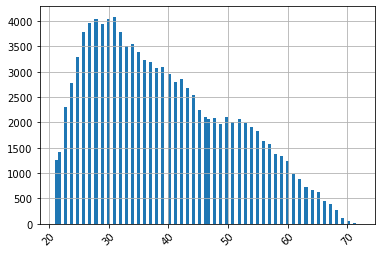

In [25]:
df['age'].hist(bins=100, xrot=45);

In [26]:
get_outlier_iqr(df, 'age')


 25-й перцентиль: 30.0, 
 75-й перцентиль: 48.0, 
 IQR: 18.0, 
 Границы выбросов: [3.0<->75.0]



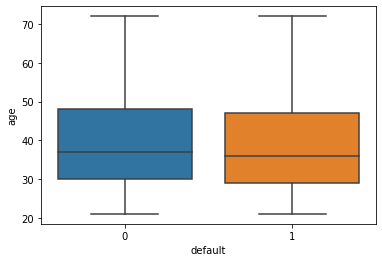

In [27]:
sns.boxplot(x=df['default'], y=df['age']);

##### Выводы:
- Выбросов нет, распределение вполне реалистичное
- В среднем возраст `default-клиентов` незначительно меньше

In [28]:
# Стандартизируем значения
scaler = StandardScaler()
# scaler = MinMaxScaler()
df['age_norm'] = scaler.fit_transform(df[['age']])

In [29]:
## Сортируем
numerical += ['age', 'age_norm']

### car - флаг наличия автомобиля

count     110148
unique         2
top            N
freq       74290
Name: car, dtype: object 
 
 Кол-во пустых значений: 0 (0.0%)


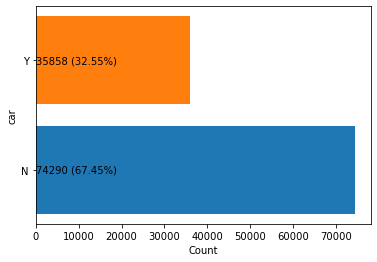

In [30]:
get_value_balance(df, 'car')

In [31]:
# Encode a categorical variable
df['car'] = le.fit_transform(df['car'])

In [32]:
## Сортируем
binary.append('car')

### car_type - флаг автомобиля иномарки

count     110148
unique         2
top            N
freq       89140
Name: car_type, dtype: object 
 
 Кол-во пустых значений: 0 (0.0%)


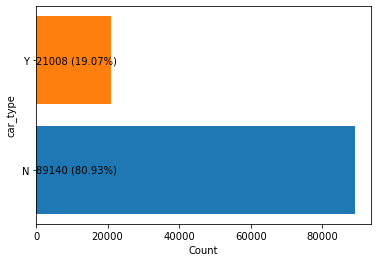

In [33]:
get_value_balance(df, 'car_type')

In [34]:
df.groupby('car')['car_type'].value_counts()[1]

car_type
Y    21008
N    14850
Name: car_type, dtype: int64

##### Выводы:
- Возможно имеет смысл объединить `car` и `car_type` (_см. Feature engineering_)

In [35]:
# Encode a categorical variable
df['car_type'] = le.fit_transform(df['car_type'])

In [36]:
## Сортируем
binary.append('car_type')

### decline_app_cnt - количество отказанных прошлых заявок

In [37]:
df['decline_app_cnt'].describe()

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

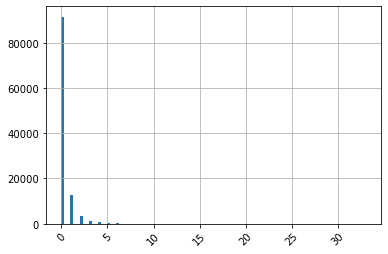

In [38]:
df['decline_app_cnt'].hist(bins=100, xrot=45);

In [39]:
get_outlier_iqr(df, 'decline_app_cnt')


 25-й перцентиль: 0.0, 
 75-й перцентиль: 0.0, 
 IQR: 0.0, 
 Границы выбросов: [0.0<->0.0]



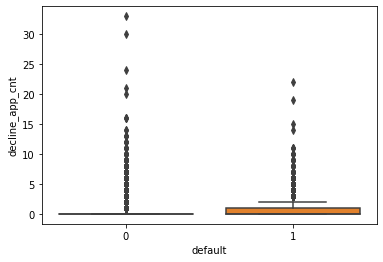

In [40]:
sns.boxplot(x=df['default'], y=df['decline_app_cnt']);

In [41]:
df['decline_app_cnt'].value_counts().head(5)

0    91471
1    12500
2     3622
3     1365
4      606
Name: decline_app_cnt, dtype: int64

##### Выводы:
- Распределение сильно не равномерное, попробуем улучшить
- Распределение совершенно четко делится на 3 группы: Заемщиков с 2 отказами на порядок меньше чем с одним. Практически тоже самое с 1 отказом и без отказов

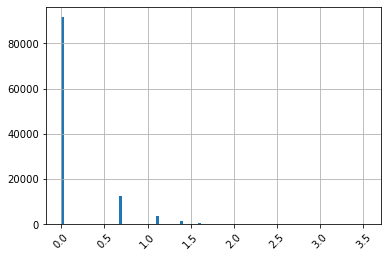

In [42]:
# Логарифмируем
df['decline_app_cnt_log'] = df['decline_app_cnt'].apply(lambda x: np.log(x+1))
df['decline_app_cnt_log'].hist(bins=100, xrot=45);

In [43]:
# Стандартизируем значения
scaler = StandardScaler()
# scaler = MinMaxScaler()
df['decline_app_cnt_log_norm'] = scaler.fit_transform(df[['decline_app_cnt_log']])

In [44]:
## Сортируем
numerical += ['decline_app_cnt', 'decline_app_cnt_log', 'decline_app_cnt_log_norm']

In [45]:
# Поделим на три группы
## 0 - без отказов, 1 - 1 отказ, 2 - 2 и более отказов
df['decline_app_cnt_encode'] = df['decline_app_cnt'].apply(lambda x: 2 if x>=2 else 1 if x==1 else 0)
# Раскидаваем по столбцам
df_decline_app_cnt = pd.get_dummies(df['decline_app_cnt_encode'])
df_decline_app_cnt.columns = ['no_decline', '1_decline', 'mm_decline']
# Добавляем
df = df.merge(df_decline_app_cnt, left_index=True, right_index=True)

In [46]:
## Сортируем
# binary += list(df_decline_app_cnt.columns)

In [47]:
# df['decline_app_cnt'] = df['decline_app_cnt'].apply(lambda x: np.sqrt(x))
# df['decline_app_cnt'].hist(bins=100, xrot=45);

In [48]:
# Заменим на бинарный параметр
# df['decline_app_cnt'] = df['decline_app_cnt'].apply(lambda x: 1 if x>0 else 0)
# df.head(1)

### good_work - флаг наличия “хорошей” работы

count    110148.000000
mean          0.165514
std           0.371645
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: good_work, dtype: float64 
 
 Кол-во пустых значений: 0 (0.0%)


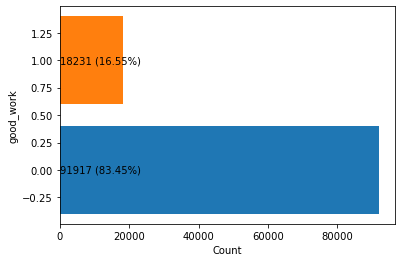

In [49]:
get_value_balance(df, 'good_work')

In [50]:
## Сортируем
binary.append('good_work')

### bki_request_cnt - количество запросов в БКИ

In [51]:
df['bki_request_cnt'].describe()

count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64

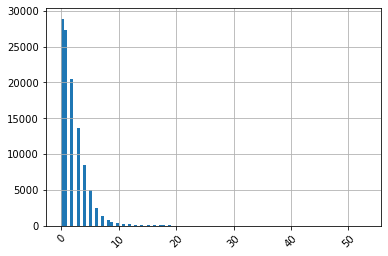

In [52]:
df['bki_request_cnt'].hist(bins=100, xrot=45);

In [53]:
get_outlier_iqr(df, 'bki_request_cnt')


 25-й перцентиль: 0.0, 
 75-й перцентиль: 3.0, 
 IQR: 3.0, 
 Границы выбросов: [-4.5<->7.5]



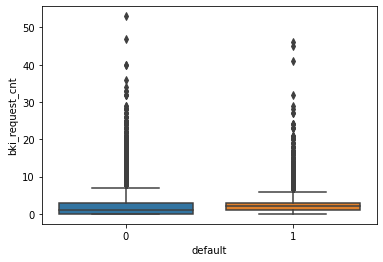

In [54]:
sns.boxplot(x=df['default'], y=df['bki_request_cnt']);

##### Выводы:
- Количество запросов у `default-клиентов` в среднем больше
- Распределение сильно не равномерное, попробуем улучшить

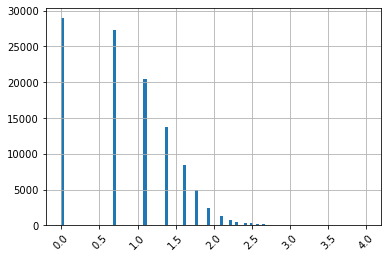

In [55]:
# Логарифмируем
df['bki_request_cnt_log'] = df['bki_request_cnt'].apply(lambda x: np.log(x+1))
# Стандартизируем
scaler = StandardScaler()
# scaler = MinMaxScaler()
df['bki_request_cnt_log_norm'] = scaler.fit_transform(df[['bki_request_cnt_log']])
df['bki_request_cnt_log'].hist(bins=100, xrot=45);

In [56]:
## Сортируем
numerical += ['bki_request_cnt', 'bki_request_cnt_log', 'bki_request_cnt_log_norm']

### home_address - категоризатор домашнего адреса

count    110148.000000
mean          1.574945
std           0.527562
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: home_address, dtype: float64 
 
 Кол-во пустых значений: 0 (0.0%)


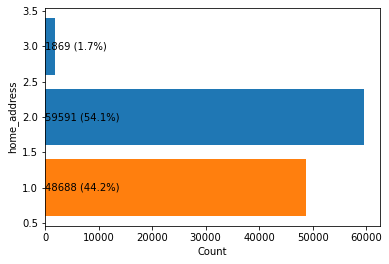

In [57]:
get_value_balance(df, 'home_address')

In [58]:
df_home_address = pd.get_dummies(df['home_address'])
df_home_address.columns = ['ha_type_1', 'ha_type_2', 'ha_type_3']

df = df.merge(df_home_address, left_index=True, right_index=True)

In [59]:
# Стандартизируем
scaler = StandardScaler()
# scaler = MinMaxScaler()
df['home_address_norm'] = scaler.fit_transform(df[['home_address']])

In [60]:
## Сортируем
categorical += ['home_address', 'home_address_norm']
# binary += list(df_home_address.columns)

### work_address - категоризатор рабочего адреса

count    110148.000000
mean          2.497867
std           0.687651
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           3.000000
Name: work_address, dtype: float64 
 
 Кол-во пустых значений: 0 (0.0%)


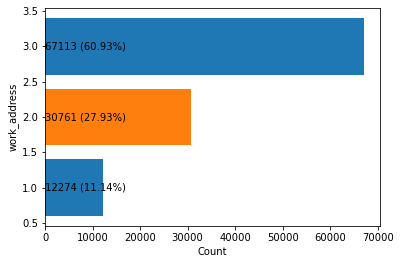

In [61]:
get_value_balance(df, 'work_address')

In [62]:
df_work_address = pd.get_dummies(df['work_address'])
df_work_address.columns = ['wa_type_1', 'wa_type_2', 'wa_type_3']

df = df.merge(df_work_address, left_index=True, right_index=True)

In [63]:
# Стандартизируем
scaler = StandardScaler()
# scaler = MinMaxScaler()
df['work_address_norm'] = scaler.fit_transform(df[['work_address']])

In [64]:
## Сортируем
categorical += ['work_address', 'work_address_norm']
# binary += list(df_work_address.columns)

### income - доход заемщика

In [65]:
df['income'].describe()

count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

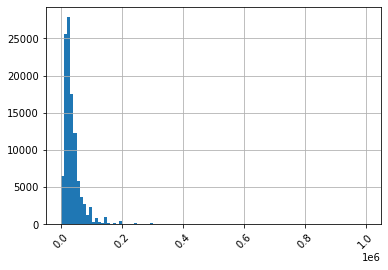

In [66]:
df['income'].hist(bins=100, xrot=45);

In [67]:
get_outlier_iqr(df, 'income')


 25-й перцентиль: 20000.0, 
 75-й перцентиль: 48000.0, 
 IQR: 28000.0, 
 Границы выбросов: [-22000.0<->90000.0]



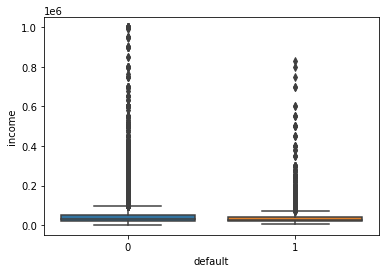

In [68]:
sns.boxplot(x=df['default'], y=df['income']);

In [69]:
df[df['income']>90000]['income'].count()/len(df)

0.0635508588444638

In [70]:
df[df['income']<10000]['income'].count()/len(df)

0.036886734212150926

##### Выводы:
- 6.4% значении намного выше среднего $\to$ их можно считать выбросами
- но т.к. 6% - достаточно большое количество данных, пока оставим

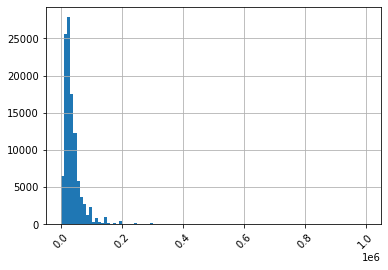

In [71]:
# Логарифмируем
df['income_log'] = df['income'].apply(lambda x: np.log(x+1))
# Стандартизируем
scaler = StandardScaler()
# scaler = MinMaxScaler()
df['income_log_norm'] = scaler.fit_transform(df[['income_log']])

df['income'].hist(bins=100, xrot=45);

In [72]:
## Сортируем
numerical += ['income', 'income_log', 'income_log_norm']

### foreign_passport - наличие загранпаспорта

count     110148
unique         2
top            N
freq       93721
Name: foreign_passport, dtype: object 
 
 Кол-во пустых значений: 0 (0.0%)


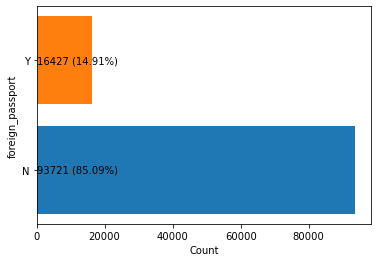

In [73]:
get_value_balance(df, 'foreign_passport')

In [74]:
df['foreign_passport'] = le.fit_transform(df['foreign_passport'])

In [75]:
## Сортируем
binary.append('foreign_passport')

### sna - связь заемщика с клиентами банка

count    110148.000000
mean          1.731588
std           1.122652
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           4.000000
Name: sna, dtype: float64 
 
 Кол-во пустых значений: 0 (0.0%)


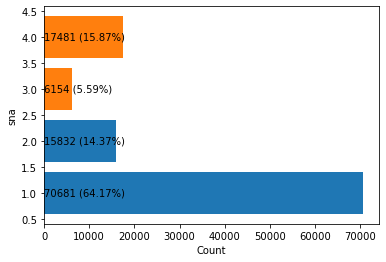

In [76]:
get_value_balance(df, 'sna')

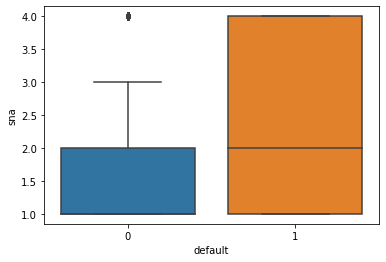

In [77]:
sns.boxplot(x=df['default'], y=df['sna']);

##### Выводы:
- Диапазон связей у `default-клиентов` больше

In [78]:
df_sna = pd.get_dummies(df['sna'])
df_sna.columns = ['sna_1kind', 'sna_2kind', 'sna_3kind', 'sna_4kind']

df = df.merge(df_sna, left_index=True, right_index=True)

In [79]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
df['sna_norm'] = scaler.fit_transform(df[['sna']])

In [80]:
## Сортируем
categorical += ['sna', 'sna_norm']
# binary += list(df_sna.columns)

### first_time - давность наличия информации о заемщике

count    110148.000000
mean          2.765570
std           1.010151
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           4.000000
Name: first_time, dtype: float64 
 
 Кол-во пустых значений: 0 (0.0%)


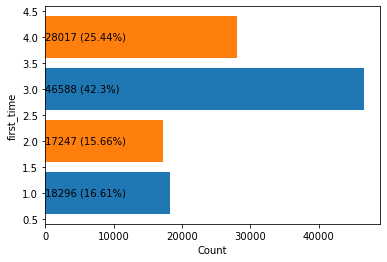

In [81]:
get_value_balance(df, 'first_time')

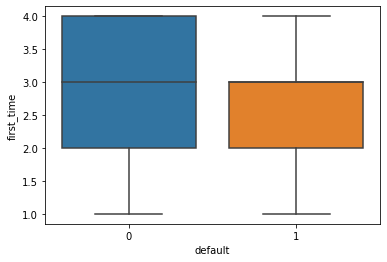

In [82]:
sns.boxplot(x=df['default'], y=df['first_time']);

In [83]:
df_first_time = pd.get_dummies(df['first_time'])
df_first_time.columns = ['1y_ago', '2y_ago', '3y_ago', '4y_ago']

df = df.merge(df_first_time, left_index=True, right_index=True)

In [84]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
df['first_time_norm'] = scaler.fit_transform(df[['first_time']])

In [85]:
## Сортируем
categorical += ['first_time', 'first_time_norm']
# binary += list(df_first_time.columns)

### score_bki - скоринговый балл по данным из БКИ

In [86]:
df['score_bki'].describe()

count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64

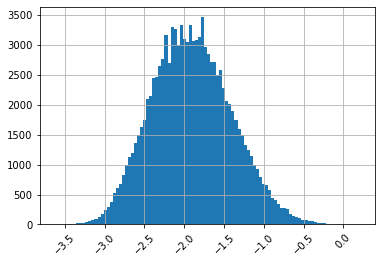

In [87]:
df['score_bki'].hist(bins=100, xrot=45);

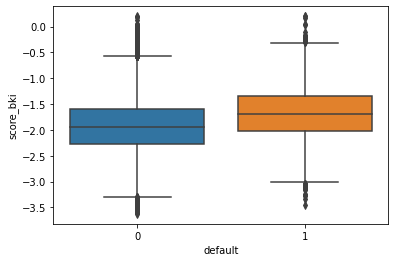

In [88]:
sns.boxplot(x=df['default'], y=df['score_bki']);

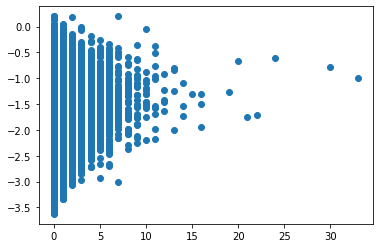

In [89]:
plt.scatter(x=df['decline_app_cnt'], y=df['score_bki']);

In [90]:
len(df[df['score_bki']>=0])

12

In [91]:
df[df['score_bki']>=0]['default']

706       1
2527      1
4383      0
14969     1
33790     1
45078     0
50938     1
58642     0
58789     0
95585     0
97896     0
101929    0
Name: default, dtype: int64

##### Выводы:
- 12 значении из 110148 положительные числа. Так как медот подсчета параметра "неизвестен", предположим, что имеем дело с ошибкой и приведем все значения к "единому" виду

In [92]:
df['score_bki_abs'] = df['score_bki'].apply(lambda x: abs(x))

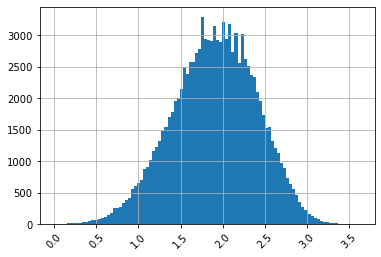

In [93]:
df['score_bki_abs'].hist(bins=100, xrot=45);

In [94]:
get_outlier_iqr(df, 'score_bki_abs')


 25-й перцентиль: 1.568, 
 75-й перцентиль: 2.26, 
 IQR: 0.693, 
 Границы выбросов: [0.529<->3.299]



##### Выводы:
- Гистограмма по форме близка к распределению Гаусса $\to$ оставим "выбросы"

In [95]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
df['score_bki_abs_norm'] = scaler.fit_transform(df[['score_bki_abs']])

In [96]:
## Сортируем
numerical += ['score_bki', 'score_bki_abs', 'score_bki_abs_norm']

### region_rating - рейтинг региона

count    110148.000000
mean         56.751189
std          13.065923
min          20.000000
25%          50.000000
50%          50.000000
75%          60.000000
max          80.000000
Name: region_rating, dtype: float64 
 
 Кол-во пустых значений: 0 (0.0%)


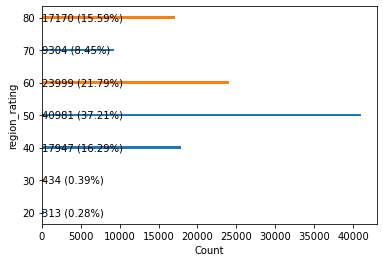

In [97]:
get_value_balance(df, 'region_rating')

In [98]:
# Кодируем
le = LabelEncoder()
df['region_rating_encode'] = le.fit_transform(df['region_rating'])
# Раскидаваем по столбцам
df_region_rating = pd.get_dummies(df['region_rating_encode'])
df_region_rating.columns = ['reg_1', 'reg_2', 'reg_3', 'reg_4', 'reg_5', 'reg_6', 'reg_7']
# Добавляем в df
df = df.merge(df_region_rating, left_index=True, right_index=True)

In [99]:
# get_outlier_iqr(df, 'region_rating')

In [100]:
# df['region_rating_perc'] = df['region_rating']/100

In [101]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
df['region_rating_norm'] = scaler.fit_transform(df[['region_rating']])

In [102]:
## Сортируем
categorical.append('region_rating_encode')
# binary += list(df_region_rating.columns)
numerical += ['region_rating', 'region_rating_norm']

### Feature engineering

#### car и car_type

Объединим параметры
- 0 - нет автомобиля `no_car`
- 1 - есть отечественный `domestic_car`
- 2 - есть иномарка `imported_car`

In [103]:
# Объединяем
df['car_common'] = df['car'] + df['car_type']
# Раскидаваем по столбцам
df_car = pd.get_dummies(df['car_common'])
df_car.columns = ['no_car', 'domestic_car', 'imported_car']
# Добавляем
df = df.merge(df_car, left_index=True, right_index=True)

In [104]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
df['car_common_norm'] = scaler.fit_transform(df[['car_common']])

In [105]:
## Сортируем
categorical += ['car_common', 'car_common_norm']
# binary += list(df_car.columns)

#### work_address и home_address

- Оказывается, большинство имеют работу в "районе" на категорию выше (если предположить, что чем выше число тем лучше) чем район проживания
- Создадим параметр из совокупности `work_address` и `home_address`

In [106]:
df['address_rate'] = pd.DataFrame(map(lambda x, y: x/y if y>0 else 0,
                                      df['work_address'], df['home_address']))
# Кодируем
le = LabelEncoder()
df['address_rate_encode'] = le.fit_transform(df['address_rate'])
# Раскидаваем по столбцам
df_address_rate = pd.get_dummies(df['address_rate_encode'])
df_address_rate.columns = ['address_rate_1', 'address_rate_2', 'address_rate_3', 'address_rate_4', 'address_rate_5', 'address_rate_6', 'address_rate_7']
# Добавляем в df
df = df.merge(df_address_rate, left_index=True, right_index=True)

In [107]:
## Сортируем
numerical.append('address_rate')
categorical.append('address_rate_encode')
# binary += list(df_address_rate.columns)

#### sna и first_time

Создадим ***условный*** (по всей видимости, параметр `decline_app_cnt` является категориальным и не отображает реальную продолжительность кредитной истории) параметр: "коэффициент отказов за кредитную историю"

In [108]:
df['decline_app_rate'] = pd.DataFrame(map(lambda x, y: x/y if y>0 else 0,
                                          df['decline_app_cnt'], df['first_time']))
scaler = StandardScaler()
# scaler = MinMaxScaler()
df['decline_app_rate_norm'] = scaler.fit_transform(df[['decline_app_rate']])

In [109]:
## Сортируем
numerical += ['decline_app_rate', 'decline_app_rate_norm']

### Подготовка данных

In [110]:
df.head(10)

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,app_date_month,app_date_day,ACD,GRD,PGR,SCH,UGR,education_norm,age_norm,decline_app_cnt_log,decline_app_cnt_log_norm,decline_app_cnt_encode,no_decline,1_decline,mm_decline,bki_request_cnt_log,bki_request_cnt_log_norm,ha_type_1,ha_type_2,ha_type_3,home_address_norm,wa_type_1,wa_type_2,wa_type_3,work_address_norm,income_log,income_log_norm,sna_1kind,sna_2kind,sna_3kind,sna_4kind,sna_norm,1y_ago,2y_ago,3y_ago,4y_ago,first_time_norm,score_bki_abs,score_bki_abs_norm,region_rating_encode,reg_1,reg_2,reg_3,reg_4,reg_5,reg_6,reg_7,region_rating_norm,car_common,no_car,domestic_car,imported_car,car_common_norm,address_rate,address_rate_encode,address_rate_1,address_rate_2,address_rate_3,address_rate_4,address_rate_5,address_rate_6,address_rate_7,decline_app_rate,decline_app_rate_norm
0,2014-02-01,3,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0,1,2,1,0,0,0,1,0,0.483982,1.975219,0.000000,-0.418815,0,1,0,0,0.693147,-0.281790,1,0,0,-1.089819,0,1,0,-0.724014,9.798183,-0.786080,0,0,0,1,2.020593,1,0,0,0,-1.747836,2.008753,0.208677,3,0,0,0,1,0,0,0,-0.516704,2,0,0,1,1.867569,2.0,5,0,0,0,0,0,1,0,0.00,-0.284837
1,2014-03-12,3,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0,1,3,12,0,0,0,1,0,0.483982,1.714757,0.000000,-0.418815,0,1,0,0,1.386294,0.770563,0,1,0,0.805701,0,0,1,0.730219,9.852247,-0.708472,0,0,0,1,2.020593,1,0,0,0,-1.747836,1.532276,-0.745622,3,0,0,0,1,0,0,0,-0.516704,0,1,0,0,-0.649827,1.5,4,0,0,0,0,1,0,0,0.00,-0.284837
2,2014-02-01,3,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0,1,2,1,0,0,0,1,0,0.483982,-1.237142,1.098612,2.621662,2,0,0,1,0.693147,-0.281790,1,0,0,-1.089819,0,1,0,-0.724014,10.308986,-0.052834,1,0,0,0,-0.651664,0,0,0,1,1.222031,1.408142,-0.994241,6,0,0,0,0,0,0,1,1.779355,1,0,1,0,0.608871,2.0,5,0,0,0,0,0,1,0,0.50,0.773065
3,2014-01-23,3,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0,1,1,23,0,0,0,1,0,0.483982,1.193834,0.000000,-0.418815,0,1,0,0,1.098612,0.333797,0,1,0,0.805701,0,0,1,0.730219,9.210440,-1.629771,1,0,0,0,-0.651664,0,0,1,0,0.232075,2.057471,0.306252,3,0,0,0,1,0,0,0,-0.516704,0,1,0,0,-0.649827,1.5,4,0,0,0,0,1,0,0,0.00,-0.284837
4,2014-04-18,1,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0,1,4,18,0,1,0,0,0,-1.369430,0.759731,0.000000,-0.418815,0,1,0,0,0.693147,-0.281790,0,1,0,0.805701,0,0,1,0.730219,10.308986,-0.052834,1,0,0,0,-0.651664,0,0,0,1,1.222031,1.244723,-1.321542,4,0,0,0,0,1,0,0,0.248649,0,1,0,0,-0.649827,1.5,4,0,0,0,0,1,0,0,0.00,-0.284837
5,2014-02-18,3,1,27,1,0,0,1,-2.032257,0,50,1,1,15000,2,3,0,0,1,2,18,0,0,0,1,0,0.483982,-1.063501,0.000000,-0.418815,0,1,0,0,0.000000,-1.334144,1,0,0,-1.089819,1,0,0,-2.178247,9.615872,-1.047783,0,1,0,0,0.239088,0,0,1,0,0.232075,2.032257,0.255752,3,0,0,0,1,0,0,0,-0.516704,1,0,1,0,0.608871,1.0,3,0,0,0,1,0,0,0,0.00,-0.284837
6,2014-02-04,3,1,39,0,0,0,0,-2.225004,0,60,1,2,28000,1,1,0,0,1,2,4,0,0,0,1,0,0.483982,-0.021654,0.000000,-0.418815,0,1,0,0,0.000000,-1.334144,1,0,0,-1.089819,0,1,0,-0.724014,10.239996,-0.151868,1,0,0,0,-0.651664,1,0,0,0,-1.747836,2.225004,0.641790,4,0,0,0,0,1,0,0,0.248649,0,1,0,0,-0.649827,2.0,5,0,0,0,0,0,1,0,0.00,-0.284837
7,2014-03-17,3,0,39,0,0,0,0,-1.522739,1,50,2,3,45000,3,3,0,0,1,3,17,0,0,0,1,0,0.483982,-0.021654,0.000000,-0.418815,0,1,0,0,0.693147,-0.281790,0,1,0,0.805701,0,0,1,0.730219,10.714440,0.529186,0,0,1,0,1.129841,0,0,1,0,0.232075,1.522739,-0.764723,3,0,0,0,1,0,0,0,-0.516704,0,1,0,0,-0.649827,1.5,4,0,0,0,0,1,0,0,0.00,-0.284837
8,2014-02-14,3,0,50,1,0,1,0,-1.676061,0,50,1,1,30000,1,4,0,0,1,2,14,0,0,0,1,0,0.483982,0.933372,0.693147,1.499512,1,0,1,0,0.000000,-1.334144,1,0,0,-1.089819,1,0,0,-2.178247,10.308986,-0.052834,1,0,0,0,-0.651664,0,0,0,1,1.222031,1.676061,-0.457647,3,0,0,0,1,0,0,0,-0.516704,1,0,1,0,0.608871,1.0,3,0,0,0,1,0,0,0,0.25,0.244114
9,2014-01-10,4,0,54,0,0,0,0,-2.695176,1,50,2,3,24000,1,3,0,0,1,1,10,0,0,0,0,1,1.410688,1.280654,0.000000,-0.418815,

In [111]:
df.shape

(110148, 83)

In [112]:
list(df.columns)

['app_date',
 'education',
 'sex',
 'age',
 'car',
 'car_type',
 'decline_app_cnt',
 'good_work',
 'score_bki',
 'bki_request_cnt',
 'region_rating',
 'home_address',
 'work_address',
 'income',
 'sna',
 'first_time',
 'foreign_passport',
 'default',
 'train',
 'app_date_month',
 'app_date_day',
 'ACD',
 'GRD',
 'PGR',
 'SCH',
 'UGR',
 'education_norm',
 'age_norm',
 'decline_app_cnt_log',
 'decline_app_cnt_log_norm',
 'decline_app_cnt_encode',
 'no_decline',
 '1_decline',
 'mm_decline',
 'bki_request_cnt_log',
 'bki_request_cnt_log_norm',
 'ha_type_1',
 'ha_type_2',
 'ha_type_3',
 'home_address_norm',
 'wa_type_1',
 'wa_type_2',
 'wa_type_3',
 'work_address_norm',
 'income_log',
 'income_log_norm',
 'sna_1kind',
 'sna_2kind',
 'sna_3kind',
 'sna_4kind',
 'sna_norm',
 '1y_ago',
 '2y_ago',
 '3y_ago',
 '4y_ago',
 'first_time_norm',
 'score_bki_abs',
 'score_bki_abs_norm',
 'region_rating_encode',
 'reg_1',
 'reg_2',
 'reg_3',
 'reg_4',
 'reg_5',
 'reg_6',
 'reg_7',
 'region_rating_norm',

In [113]:
drop_list = ['default',
             'app_date',
             'education',
#              'sex',
             'age',
#              'car',
#              'car_type',
             'decline_app_cnt',
#              'good_work',
             'score_bki',
             'bki_request_cnt',
             'region_rating',
             'home_address',
             'work_address',
             'income',
             'sna',
             'first_time',
#              'foreign_passport',
             'app_date_month',
             'app_date_day',
#              'ACD',
#              'GRD',
#              'PGR',
#              'SCH',
#              'UGR',
             'education_norm',
#              'age_norm',
#              'reg_1',
#              'reg_2',
#              'reg_3',
#              'reg_4',
#              'reg_5',
#              'reg_6',
#              'reg_7',
             'region_rating_encode',
             'region_rating_norm',
             'car_common',
             'no_car',
             'domestic_car',
             'imported_car',
             'car_common_norm',
             'decline_app_cnt_log',
             'decline_app_cnt_log_norm',
             'decline_app_cnt_encode',
#              'no_decline',
#              '1_decline',
#              'mm_decline',
             'bki_request_cnt_log',
#              'bki_request_cnt_log_norm',
#              'ha_type_1',
#              'ha_type_2',
#              'ha_type_3',
             'home_address_norm',
#              'wa_type_1',
#              'wa_type_2',
#              'wa_type_3',
             'work_address_norm',
             'address_rate',
             'address_rate_encode',
             'address_rate_1',
             'address_rate_2',
             'address_rate_3',
             'address_rate_4',
             'address_rate_5',
             'address_rate_6',
             'address_rate_7',
             'income_log',
#              'income_log_norm',
#              'sna_1kind',
#              'sna_2kind',
#              'sna_3kind',
#              'sna_4kind',
             'sna_norm',
#              '1y_ago',
#              '2y_ago',
#              '3y_ago',
#              '4y_ago',
             'first_time_norm',
             'score_bki_abs',
#              'score_bki_abs_norm',
             'decline_app_rate',
             'decline_app_rate_norm'
            ]

In [114]:
train_data = df.query('train == 1').drop(['train'], axis=1)
test_data = df.query('train == 0').drop(['train'], axis=1)

In [115]:
Y = train_data.default.values
X = train_data.drop(drop_list, axis=1)

### Оценка значимости переменных

In [116]:
numerical

['age',
 'age_norm',
 'decline_app_cnt',
 'decline_app_cnt_log',
 'decline_app_cnt_log_norm',
 'bki_request_cnt',
 'bki_request_cnt_log',
 'bki_request_cnt_log_norm',
 'income',
 'income_log',
 'income_log_norm',
 'score_bki',
 'score_bki_abs',
 'score_bki_abs_norm',
 'region_rating',
 'region_rating_norm',
 'address_rate',
 'decline_app_rate',
 'decline_app_rate_norm']

<AxesSubplot:>

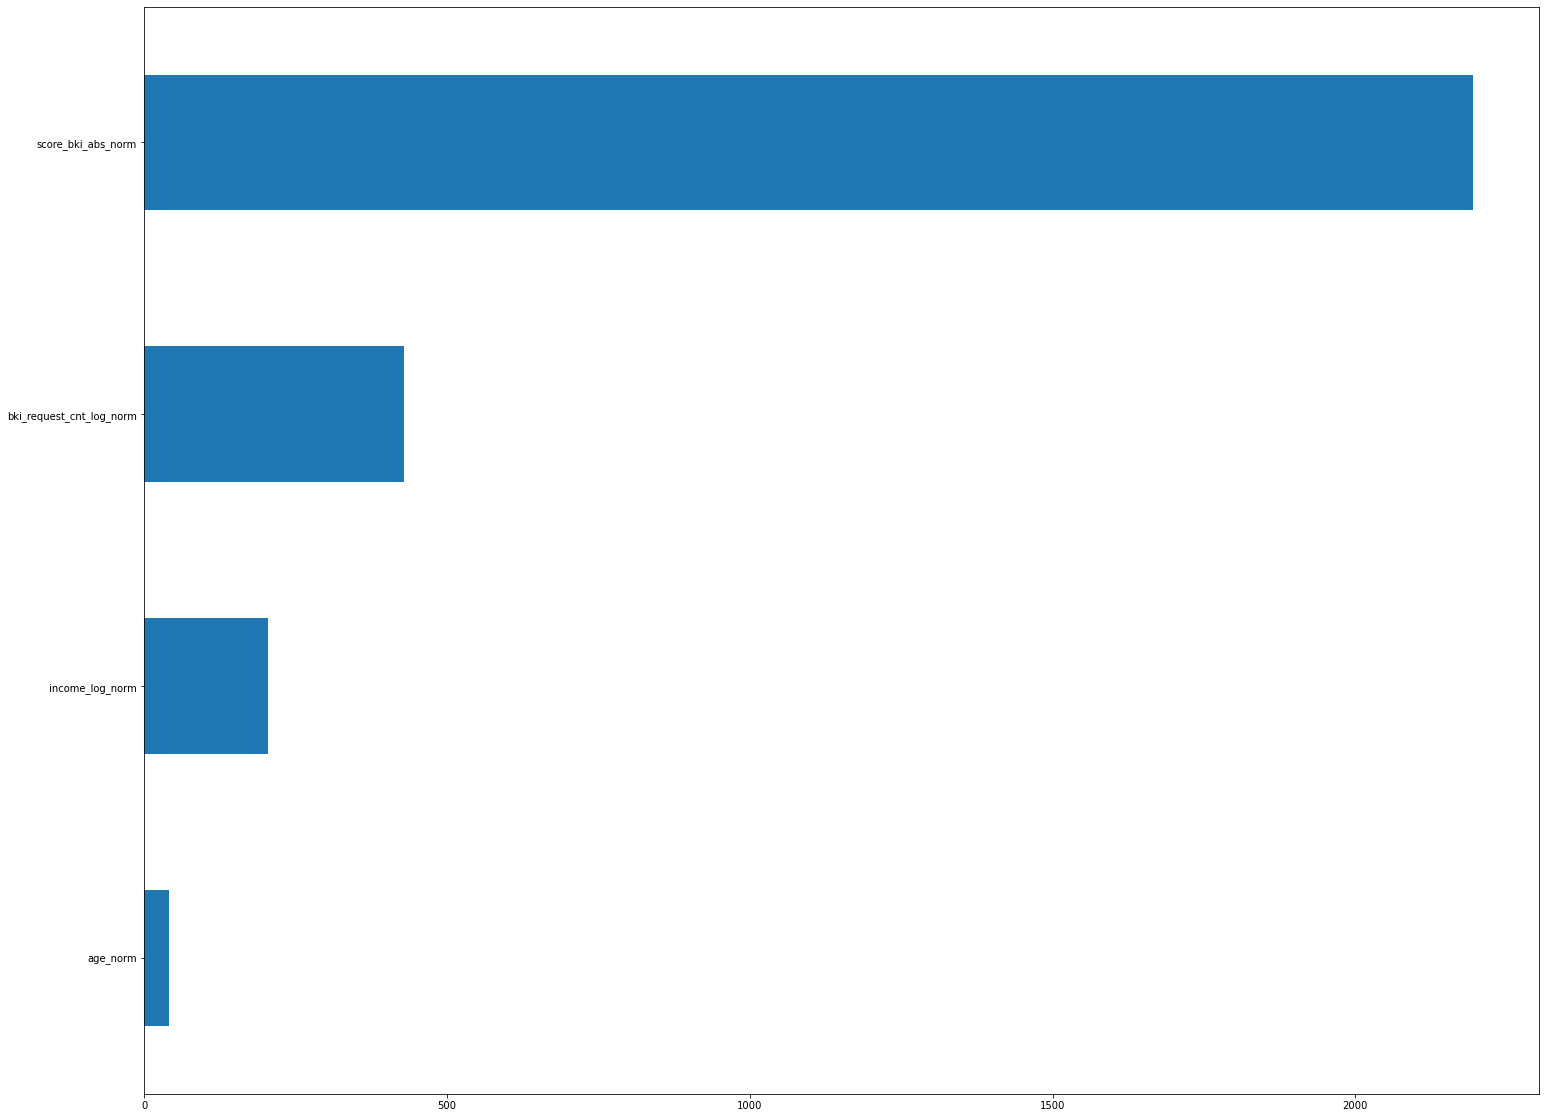

In [117]:
num_col = []
for i in numerical:
    if i not in drop_list:
        num_col.append(i)

i_numerical = pd.Series(f_classif(df[num_col], df['default'])[0], index = num_col)
plt.subplots(figsize=(25, 20))
i_numerical.sort_values(inplace = True)
i_numerical.plot(kind = 'barh')

In [118]:
binary

['sex',
 'car',
 'car_type',
 'good_work',
 'foreign_passport',
 'address_rate_1',
 'address_rate_2',
 'address_rate_3',
 'address_rate_4',
 'address_rate_5',
 'address_rate_6',
 'address_rate_7']

<AxesSubplot:>

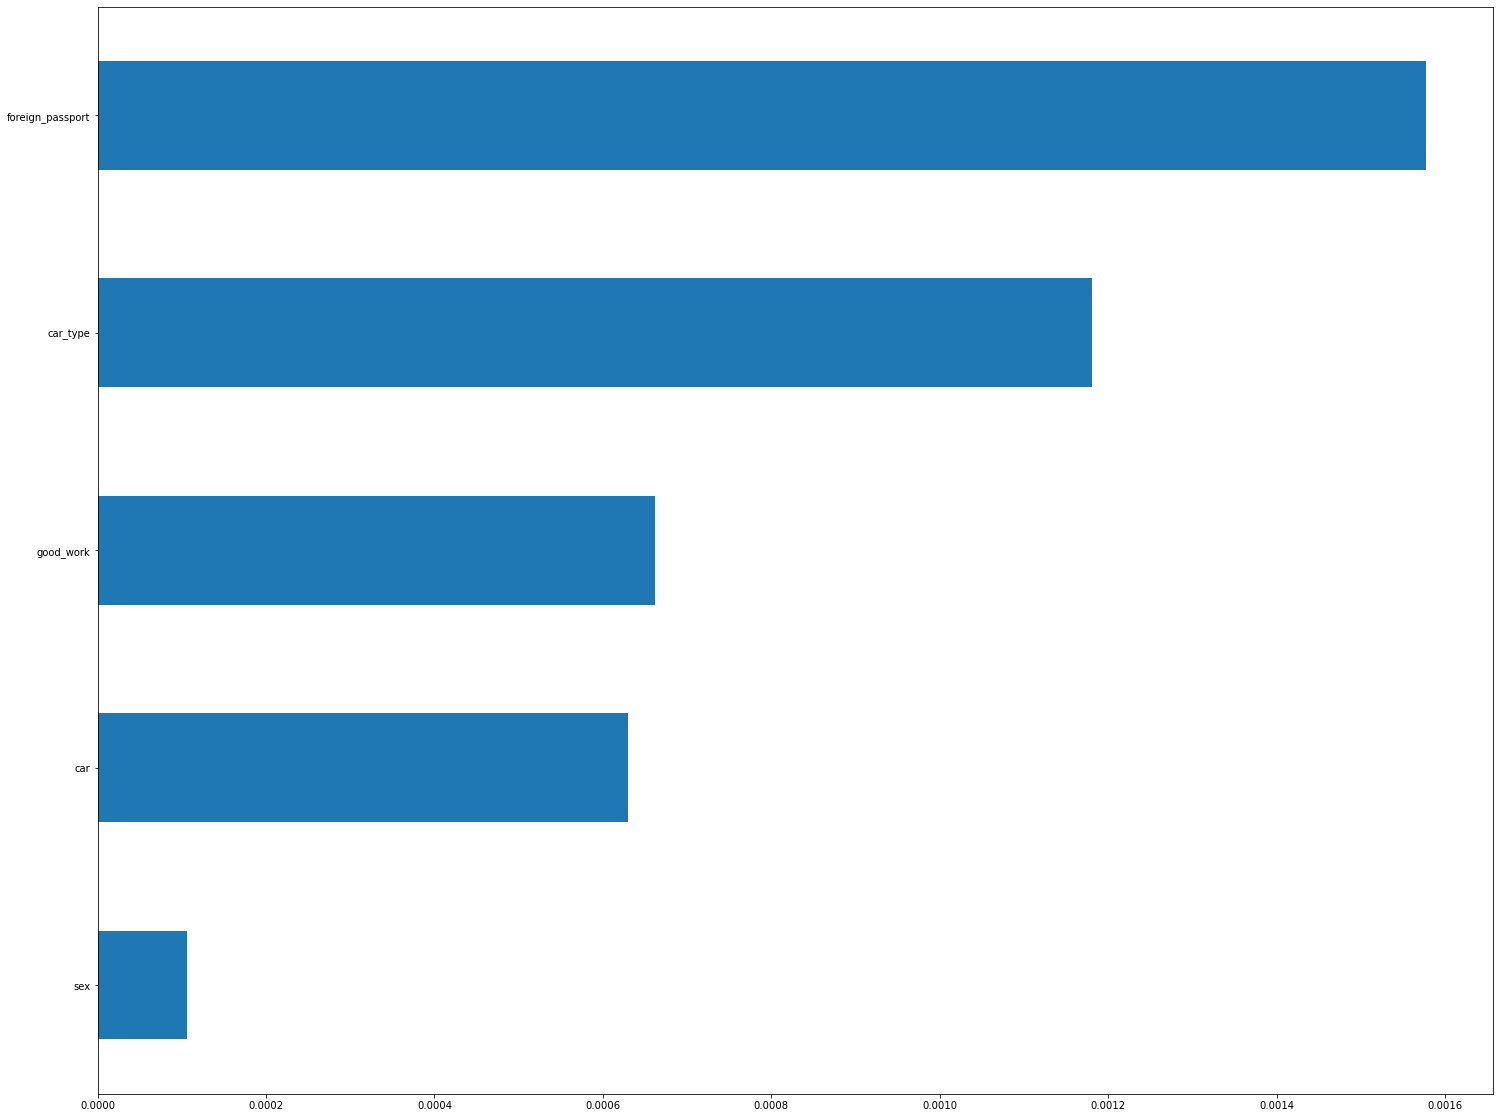

In [119]:
bin_col = []
for i in binary:
    if i not in drop_list:
        bin_col.append(i)

i_binary = pd.Series(mutual_info_classif(df[bin_col], df['default'],
                                         discrete_features =True), index = bin_col)
plt.subplots(figsize=(25, 20))
i_binary.sort_values(inplace = True)
i_binary.plot(kind = 'barh')

In [120]:
categorical

['education',
 'education_norm',
 'home_address',
 'home_address_norm',
 'work_address',
 'work_address_norm',
 'sna',
 'sna_norm',
 'first_time',
 'first_time_norm',
 'region_rating_encode',
 'car_common',
 'car_common_norm',
 'address_rate_encode']

<AxesSubplot:>

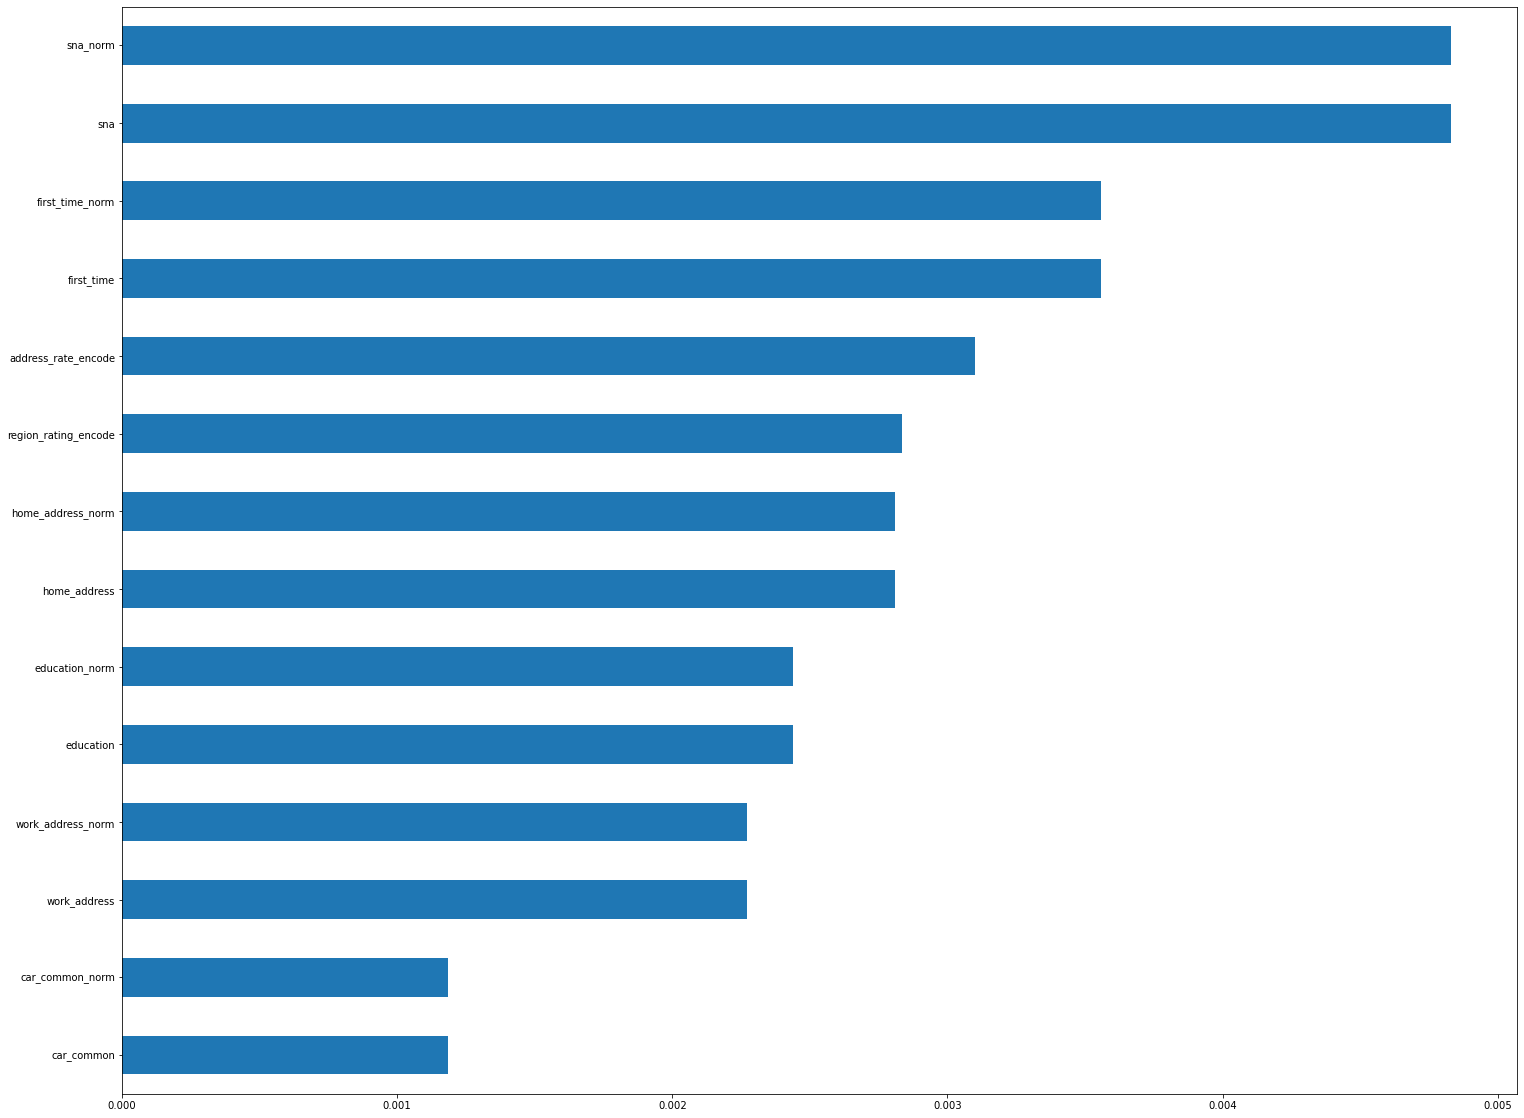

In [121]:
cat_col = []
for i in categorical:
    if i not in drop_list:
        cat_col.append(i)
    else:
        cat_col = categorical

i_categorical = pd.Series(mutual_info_classif(df[cat_col], df['default'],
                                              discrete_features =True), index = cat_col)
plt.subplots(figsize=(25, 20))
i_categorical.sort_values(inplace = True)
i_categorical.plot(kind = 'barh')

### Корреляция

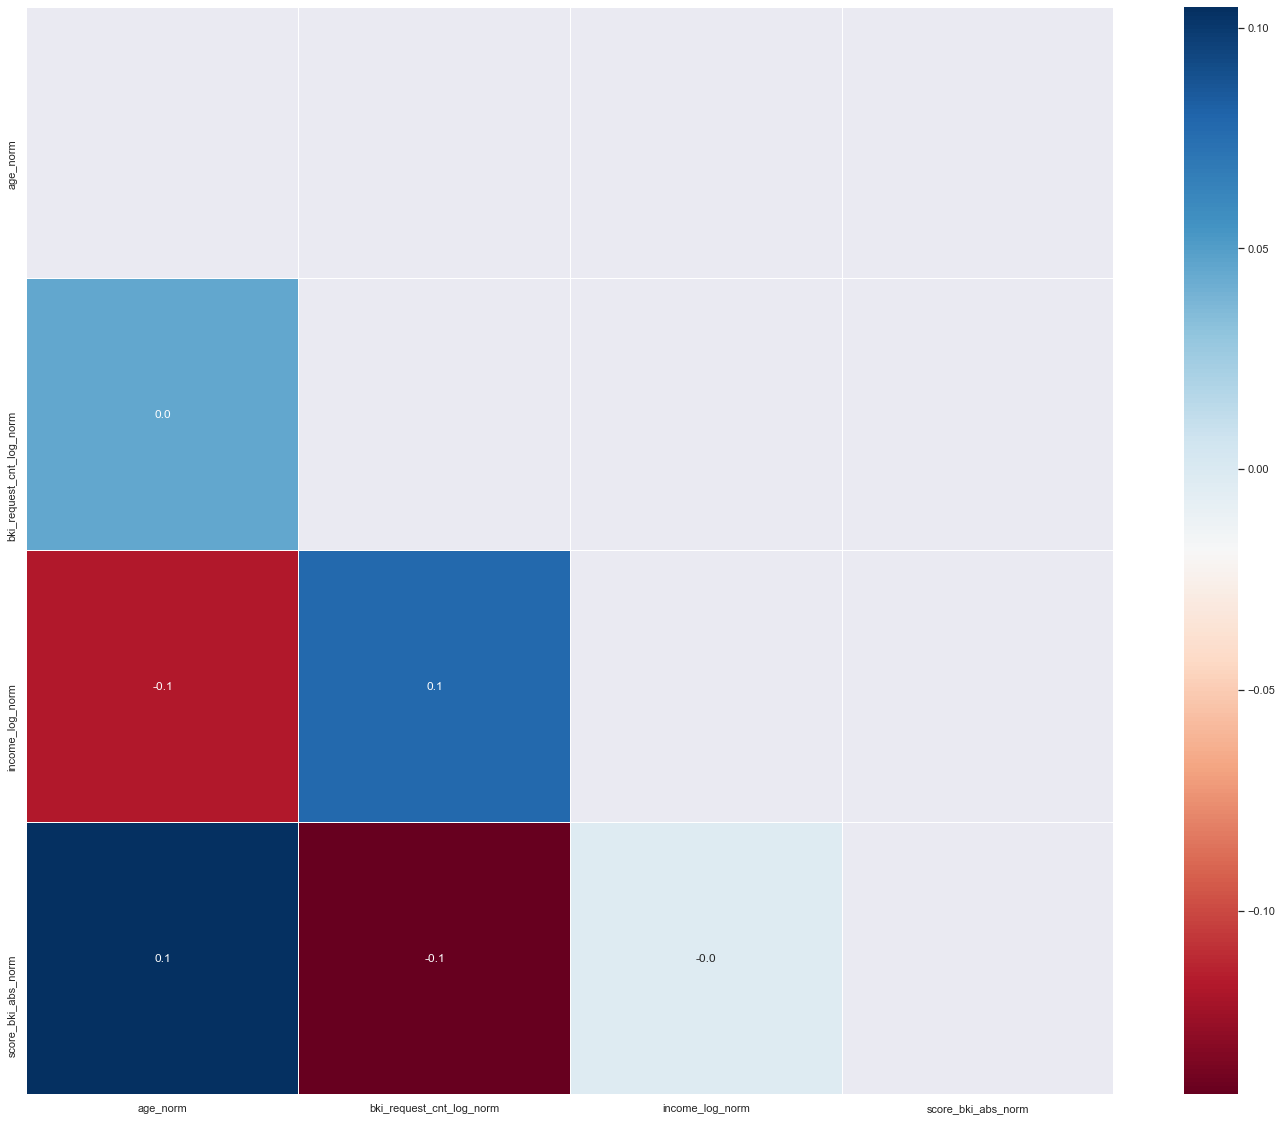

In [122]:
corr = df[num_col].corr()

sns.set(font_scale=1)
plt.subplots(figsize=(25, 20))
mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr, mask=mask, square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");

### Подготовка данных к машинному обучению

In [123]:
# Чтобы решить проблему дисбаланса классов, можно использовать Over или UnderSampling
# Используем UnderSampling
rus = RandomUnderSampler(random_state = RANDOM_SEED)
X_resampled, Y_resampled = rus.fit_resample(X, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=RANDOM_SEED)

In [124]:
print(X_resampled.shape, Y_resampled.shape)

(18744, 38) (18744,)


### LogisticRegression

In [125]:
# LogisticRegression
model = LogisticRegression(random_state = RANDOM_SEED)
model.fit(X_train, Y_train)

# Prediction
Y_pred = model.predict(X_test)

# Probability
Y_prob = model.predict_proba(X_test)
Y_prob = Y_prob[:, 1]


 Accuracy: 0.678 
 Precision: 0.67 
 Recall: 0.69 
 F1_score: 0.68


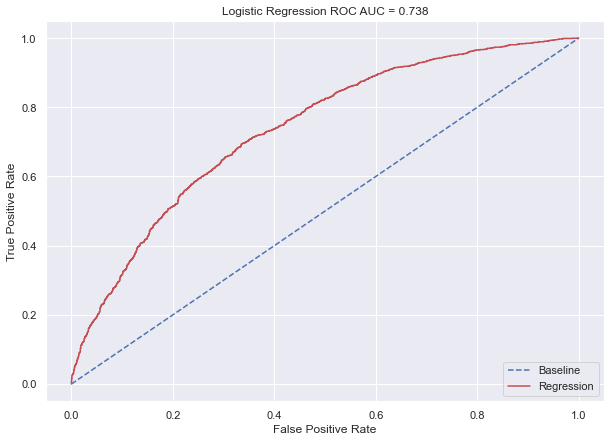

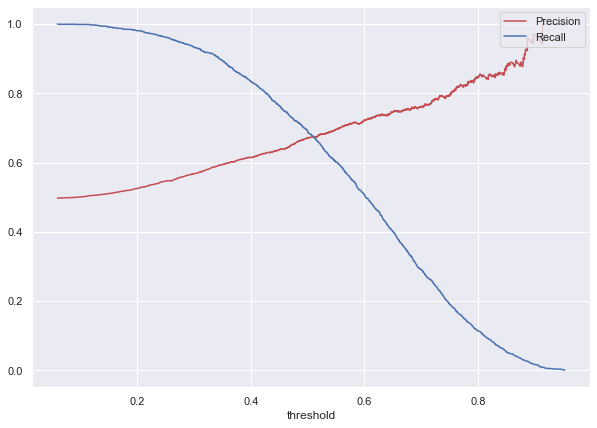

Normalized confusion matrix
[[0.66560678 0.33439322]
 [0.3104189  0.6895811 ]]


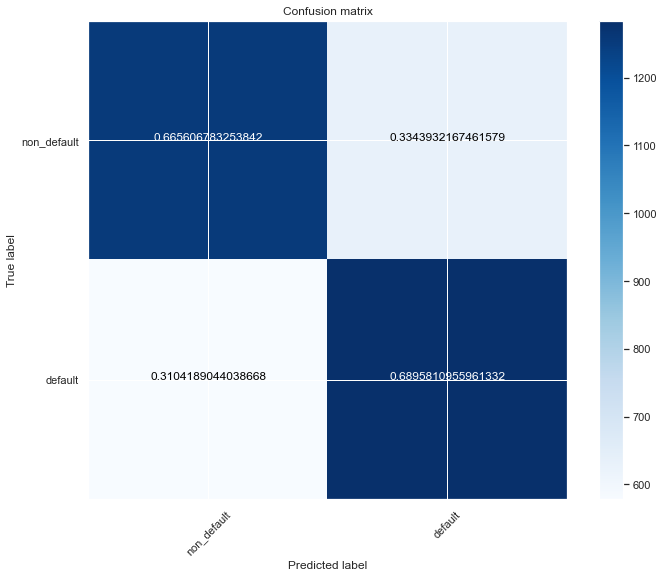

In [126]:
get_metrics(Y_test, Y_pred)


plot_roc_auc(Y_test, Y_prob)


plot_pr_curve(Y_test, Y_prob)


cnf_matrix = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], title='Confusion matrix')
plt.show()

### LogisticRegression + Regularization

In [127]:
C = np.logspace(0.01, 2, 15)

param_grid = [{'penalty': ['l1'],
               'C': C,
               'solver': ['liblinear', 'lbfgs'],
               'multi_class': ['auto', 'ovr']},
              {'penalty': ['l2'],
               'C': C,
               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               'multi_class': ['auto', 'ovr']},
              {'penalty': ['none'],
               'C': C,
               'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
               'multi_class': ['auto', 'ovr']}
             ]

model = LogisticRegression()
clf = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=True)

grid = clf.fit(X_train, Y_train)
grid = grid.best_estimator_.get_params()


C = grid['C']
penalty = grid['penalty']
solver = grid['solver']
multi_class = grid['multi_class']
class_weight = grid['class_weight']

grid

Fitting 5 folds for each of 330 candidates, totalling 1650 fits


{'C': 1.023292992280754,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'sag',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [128]:
# LogisticRegression
model = LogisticRegression(C=C,
                           penalty=penalty,
                           solver=solver,
                           multi_class=multi_class,
                           class_weight=class_weight,
                           n_jobs=-1,
                           random_state=RANDOM_SEED)

model.fit(X_train, Y_train)

# Prediction
Y_pred = model.predict(X_test)

# Probability
Y_prob = model.predict_proba(X_test)
Y_prob = Y_prob[:, 1]


 Accuracy: 0.678 
 Precision: 0.67 
 Recall: 0.69 
 F1_score: 0.68


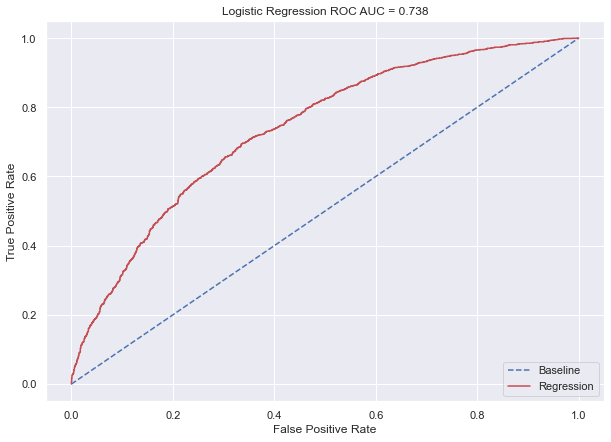

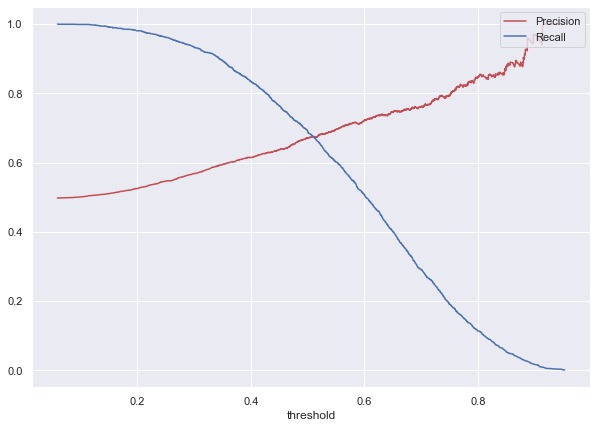

Normalized confusion matrix
[[0.66560678 0.33439322]
 [0.3104189  0.6895811 ]]


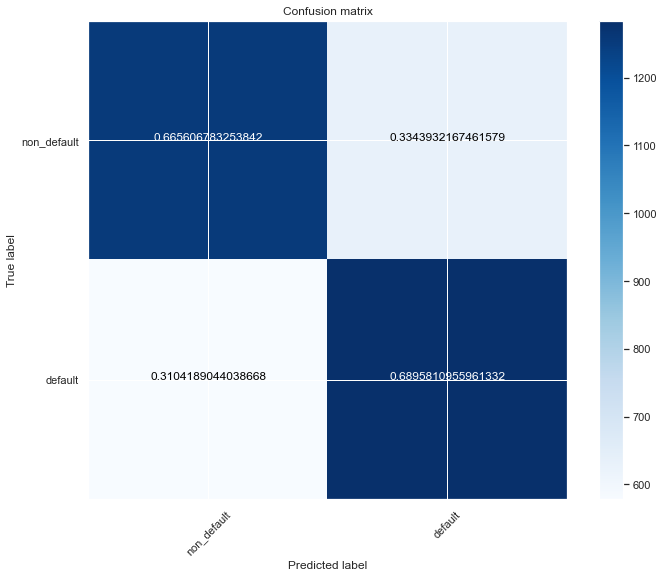

In [129]:
get_metrics(Y_test, Y_pred)


plot_roc_auc(Y_test, Y_prob)


plot_pr_curve(Y_test, Y_prob)


cnf_matrix = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], title='Confusion matrix')
plt.show()

### LogisticRegression + Cross-validation

In [130]:
# LogisticRegressionCV
model = LogisticRegressionCV(cv=5, random_state = RANDOM_SEED)
model.fit(X_train, Y_train)

# Prediction
Y_pred = model.predict(X_test)

# Probability
Y_prob = model.predict_proba(X_test)
Y_prob = Y_prob[:,1]


 Accuracy: 0.677 
 Precision: 0.67 
 Recall: 0.689 
 F1_score: 0.679


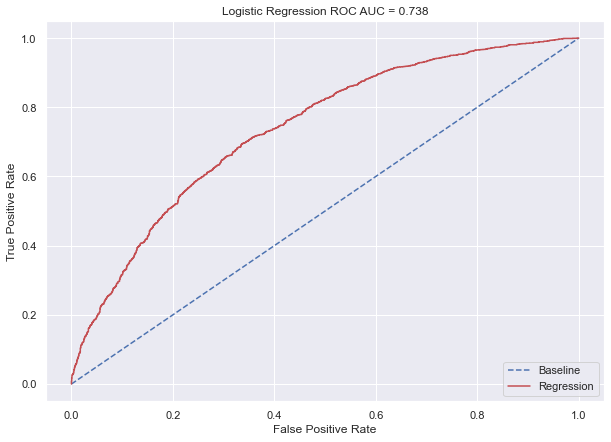

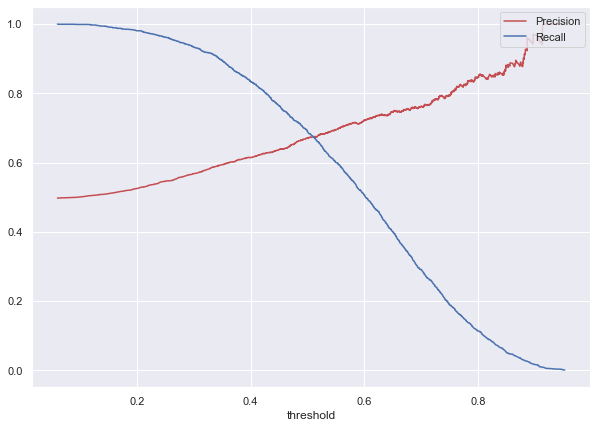

Normalized confusion matrix
[[0.66560678 0.33439322]
 [0.31149302 0.68850698]]


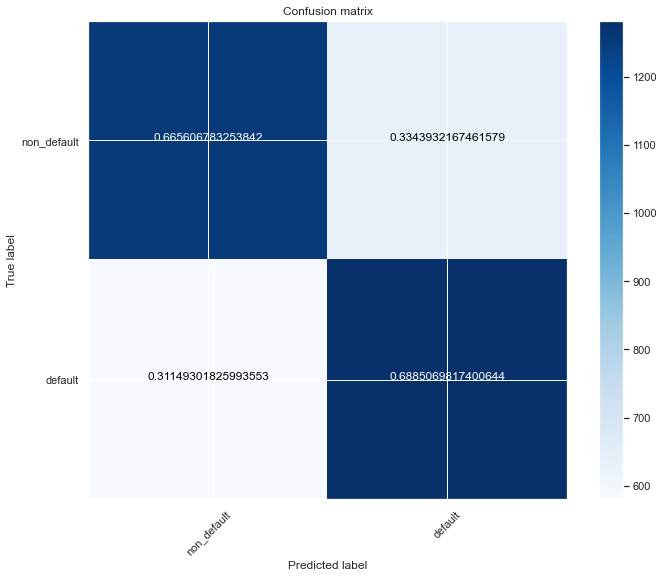

In [131]:
get_metrics(Y_test, Y_pred)


plot_roc_auc(Y_test, Y_prob)


plot_pr_curve(Y_test, Y_prob)


cnf_matrix = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], title='Confusion matrix')
plt.show()

### LogisticRegression + Cross-validation + Regularization

In [132]:
Cs = [np.logspace(0.01, 2, 15)]
epsilon = [1e-2]
param_grid = [{'penalty': ['l1'],
               'Cs': Cs,
               'tol': epsilon,
               'solver': ['liblinear', 'saga'],
               'class_weight': ['None', 'balanced'],
               'multi_class': ['auto', 'ovr']},
              {'penalty': ['l2'],
               'Cs': Cs,
               'tol': epsilon,
               'solver': ['newton-cg', 'lbfgs', 'sag'],
               'class_weight': ['None', 'balanced'],
               'multi_class': ['auto', 'ovr', 'multinomial']},
              {'penalty': ['elasticnet'],
               'Cs': Cs,
               'tol': epsilon,
               'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
               'class_weight': ['None', 'balanced'],
               'multi_class': ['auto', 'ovr']}
              ]

model = LogisticRegressionCV()
clf = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=True)

grid = clf.fit(X_train, Y_train)
grid = grid.best_estimator_.get_params()

Cs = grid['Cs']
penalty = grid['penalty']
solver = grid['solver']
multi_class = grid['multi_class']

grid

Fitting 5 folds for each of 46 candidates, totalling 230 fits


{'Cs': array([  1.02329299,   1.41952438,   1.96918135,   2.73167213,
          3.78940853,   5.25671323,   7.29217601,  10.11579454,
         14.03275223,  19.46640319,  27.00402936,  37.46031531,
         51.96540133,  72.08703166, 100.        ]),
 'class_weight': 'balanced',
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'liblinear',
 'tol': 0.01,
 'verbose': 0}

In [133]:
# LogisticRegressionCV
model = LogisticRegressionCV(Cs=Cs,
                             penalty=penalty,
                             multi_class=multi_class,
                             solver=solver,
                             cv=5,
                             n_jobs=-1,
                             random_state=RANDOM_SEED)

model.fit(X_train, Y_train)

# Prediction
Y_pred = model.predict(X_test)

# Probability
Y_prob = model.predict_proba(X_test)
Y_prob = Y_prob[:, 1]


 Accuracy: 0.677 
 Precision: 0.67 
 Recall: 0.689 
 F1_score: 0.679


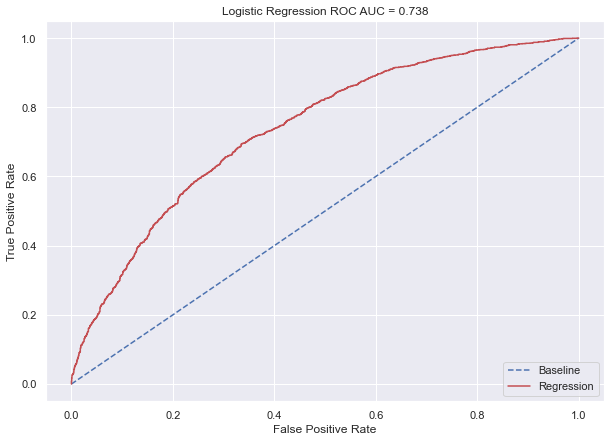

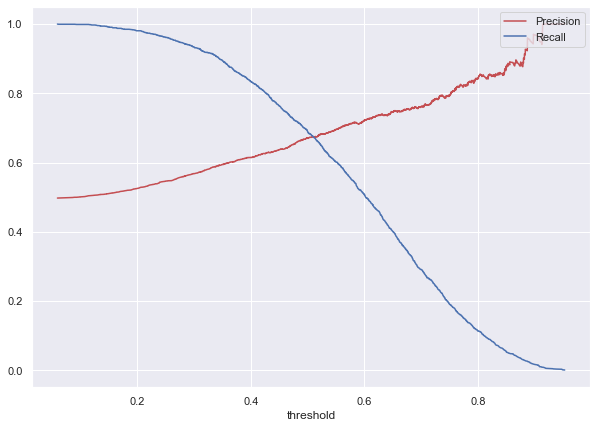

Normalized confusion matrix
[[0.66560678 0.33439322]
 [0.31149302 0.68850698]]


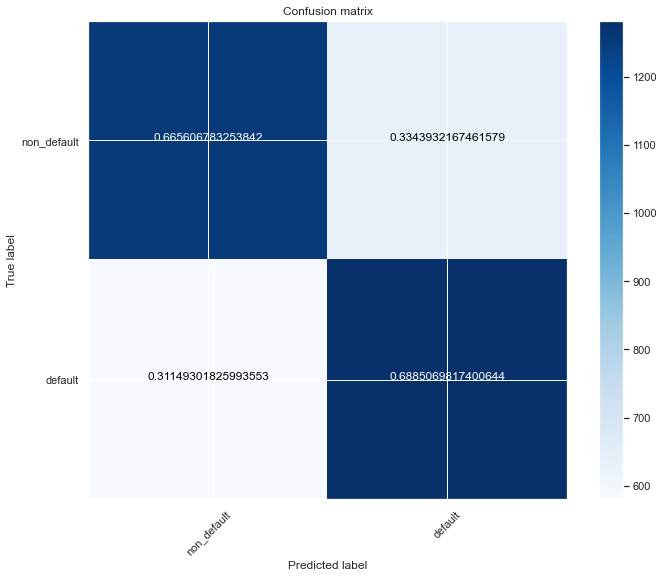

In [134]:
get_metrics(Y_test, Y_pred)


plot_roc_auc(Y_test, Y_prob)


plot_pr_curve(Y_test, Y_prob)


cnf_matrix = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], title='Confusion matrix')
plt.show()

# !!!
**Результаты остальных моделей (`Decision Tree Regressor`, `RandomForestClassifier`, `XGBoostClassifier`, `LGBM Classifier`) в файле для Kaggle** ([sf-dst-credit-scoring.ipynb](https://github.com/NormKOALA/Projects/blob/master/module_4/sf-dst-credit-scoring.ipynb))

### Выводы:

1. Важно учитывать и исправлять несбалансированность классов. Иначе модель имеет тенденцию склоняться к наибольшему классу

2. Для категориальных параметров OneHotEncoder предпочтительнее, т.к. образуется "связь" между значениями переменной, нежели когда переменные "записаны" в один столбец

3. Испробовано несколько моделей (в том числе и с регуляризацией). Наилучший результат показала модель `LGBM Classifier`:
    - F1_score = 0.683
    - Ошибка второго рода наименьшая из всех
    - Ошибка первого рода незначительно выше (но для данной задачи Ошибка второго рода приоритетнее)
    - Kaggle (ROC-AUC) = 0.73356



4. Feature engineering не дал какого-либо существенного улучшения результат

5. Разница с первыми местами около 0.01 балла. Анализ кода "соперников" склоняет к мысли, что разница (в 0.01 балла) продиктована ВЕЛИКИМ рандомом. (Т.к. есть разница даже в результатах полученных на локальном ПК и Kaggle)